Layer by Layer
We need to keep in mind the big picture here :

* We feed input data into the neural network.
* The data flows from layer to layer until we have the output.
* Once we have the output, we can calculate the error which is a scalar.
* Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.
* We iterate through that process.

The most important step is the `4th`. We want to be able to have as many layers as we want, and of any type. But if we modify/add/remove one layer from the network, the output of the network is going to change, which is going to change the error, which is going to change the derivative of the error with respect to the parameters. We need to be able to compute the derivatives regardless of the network architecture, regardless of the activation functions, regardless of the loss we use.

In order to achieve that, we must implement each layer separately.

In [1]:
# Base class
class Layer:
    """
    The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.
    """

    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError


## Fully Connected Layer
Now let's define and implement the first type of layer: fully connected layer or FC layer. FC layers are the most basic layers as every input neurons are connected to every output neurons.

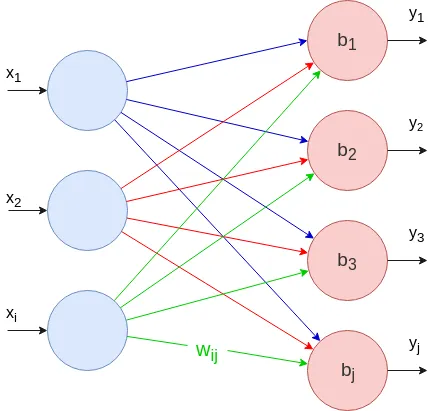

## Forward Propagation
The value of each output neuron can be calculated as the following :

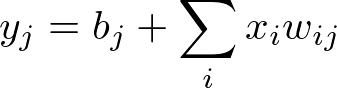

With matrices, we can compute this formula for every output neuron in one shot using a dot product :

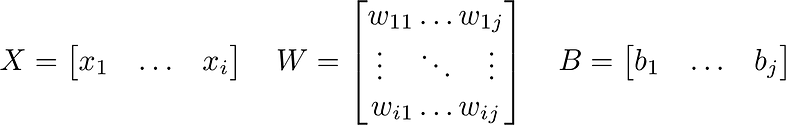

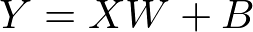

We’re done with the forward pass. Now let’s do the backward pass of the FC layer.

## Backward Propagation

As we said, suppose we have a matrix containing the derivative of the error with respect to that layer’s output (∂E/∂Y). We need :

* The derivative of the error with respect to the parameters (∂E/∂W, ∂E/∂B)
* The derivative of the error with respect to the input (∂E/∂X)

## Coding the Fully Connected Layer

In [2]:
import numpy as np


class FCLayer(Layer):
    """
    Coding the Fully Connected Layer inherits from base class Layer
    # Arguments
        input_size: number of input neurons
        output_size: number of output neurons
    """

    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


## Activation Layer
All the calculation we did until now were completely linear. It's hopeless to learn anything with that kind of model. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

In [3]:
# inherit from base class Layer
class ActivationLayer(Layer):
    """
    Coding the Activation Layer inherits from base class Layer
    """
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error


In [4]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

## Loss Function

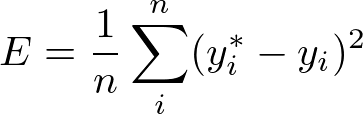

In [5]:
import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

# MSE derivative
def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

## Network Class

In [6]:
class Network:
    """
    Build Neural Network
    """
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))


## Solve XOR

Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [7]:
# training data
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=100, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)


epoch 1/100   error=0.454069
epoch 2/100   error=0.338617
epoch 3/100   error=0.317181
epoch 4/100   error=0.309692
epoch 5/100   error=0.305760
epoch 6/100   error=0.303138
epoch 7/100   error=0.301145
epoch 8/100   error=0.299511
epoch 9/100   error=0.298110
epoch 10/100   error=0.296869
epoch 11/100   error=0.295747
epoch 12/100   error=0.294713
epoch 13/100   error=0.293748
epoch 14/100   error=0.292838
epoch 15/100   error=0.291971
epoch 16/100   error=0.291138
epoch 17/100   error=0.290333
epoch 18/100   error=0.289549
epoch 19/100   error=0.288781
epoch 20/100   error=0.288024
epoch 21/100   error=0.287275
epoch 22/100   error=0.286530
epoch 23/100   error=0.285785
epoch 24/100   error=0.285037
epoch 25/100   error=0.284282
epoch 26/100   error=0.283519
epoch 27/100   error=0.282742
epoch 28/100   error=0.281951
epoch 29/100   error=0.281141
epoch 30/100   error=0.280309
epoch 31/100   error=0.279454
epoch 32/100   error=0.278572
epoch 33/100   error=0.277661
epoch 34/100   erro